In [299]:
import cv2
import glob
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from skimage.feature import hog
from skimage import data, exposure
from skimage.exposure import rescale_intensity
from skimage.util import invert
from skimage.morphology import disk, square, erosion, dilation, area_closing, remove_small_objects

In [92]:
# first data, read CSV + image
path = '../../Data/'
f_img = cv2.imread(path + 'ex01.jpg')
gray_f_img = cv2.cvtColor(f_img, cv2.COLOR_BGR2GRAY)
f_gt = pd.read_csv(path + 'ex01.csv', header=None)

In [93]:
def plot_img(img, gt, title):
    xs = list(gt[0])
    ys = list(gt[1])
    plt.figure(figsize=(10,8))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    for idx in range(len(xs)):
        j, i = ys[idx], xs[idx]
        plt.scatter(j, i, color='r')
    plt.show()

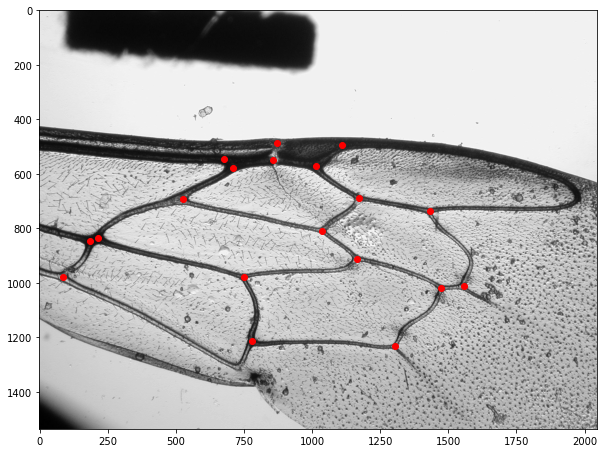

In [94]:
plot_img(gray_f_img, f_gt, '')

In [98]:
def preprocess_img(img, f_gt, display=False):
    '''
    Preprocess the input image with morphology
    '''
    # Rescale the intensity
    p1, p2 = np.percentile(gray_f_img, (10, 98))
    gray_img_rescale = rescale_intensity(img, in_range=(p1, p2))

    if display:
        plt.imshow(gray_img_rescale, cmap='gray')
        plt.show()
        
    # binarisation of the image
    threshold_val = 100
    ret, img = cv2.threshold(gray_img_rescale, threshold_val, 255, 0)

    if display:
        plt.imshow(img, cmap='gray')
        plt.show()
        
    # remove small object from the image with morphology func
    img = img > 0
    res = remove_small_objects(invert(img), min_size=400)
    
    if display:
        plt.imshow(invert(res), cmap='gray')
        plt.show()
        plot_img(invert(res), f_gt, '')
        plt.show()
    
    return invert(res)

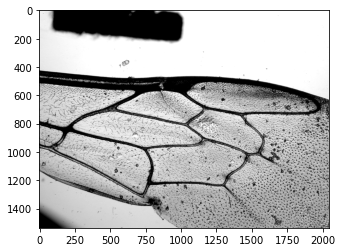

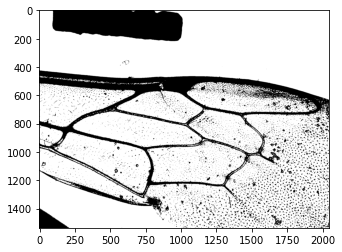

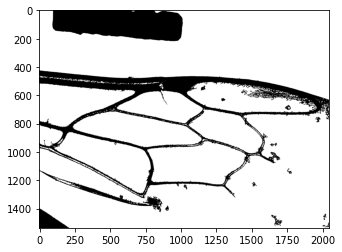

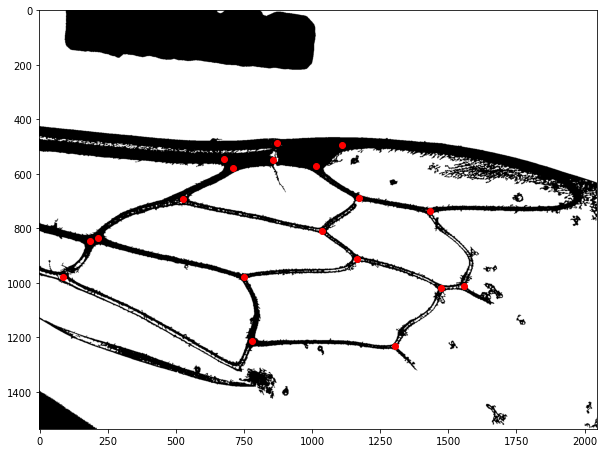

In [99]:
processed_img = preprocess_img(gray_f_img, f_gt, display=True)

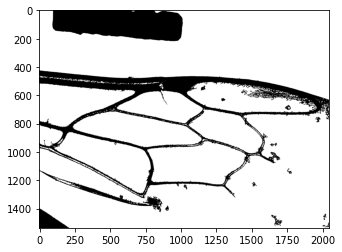

In [103]:
plt.imshow(processed_img, cmap='gray')

In [279]:
def aug_img(img_window):
    '''
    Data augmentation function
    '''
    #print(img_window.dtype)
    shape = img_window.shape
    img_window_reshaped = img_window.reshape((1, shape[0], shape[1]))
    data_aug = np.empty((8, shape[0], shape[1]))
    data_aug[0] = img_window.copy()
                        
    seq1 = iaa.Sequential([
        iaa.Fliplr(1.0),
        iaa.blur.AverageBlur()
    ])

    seq2 = iaa.Sequential([
        iaa.Affine(rotate=(-45, 45)),
        iaa.GaussianBlur()
    ])

    seq3 = iaa.Sequential([
        iaa.Flipud(1.0),
        iaa.blur.AverageBlur()
    ])

    seq4 = iaa.Sequential([
        iaa.Flipud(0.9),
        iaa.Fliplr(0.9),
    ])

    seq5 = iaa.Sequential([
        iaa.Rot90([1, 3])
    ])
    seq6 = iaa.Sequential([
        iaa.MaxPooling(3)
    ])

    seq7 = iaa.Sequential([
        iaa.AveragePooling(3)
    ])
    seqs = [seq1, seq3, seq4, seq5, seq6, seq7]
    
    for idx, s in enumerate(seqs):
        data_aug[idx + 1] = s(images=img_window_reshaped)[0]
    
    data_aug[-1] = invert(seq2(images=invert(img_window_reshaped))[0])

    return data_aug

In [288]:
def get_hog_intersect_data(img, f_gt, w_radius=128, display=False):
    '''
    Get the HOG feature vector for all the intersections of one image
    '''
    img = img.astype(np.float32)

    # padd img in the case points are close to the borders
    img_padded = np.pad(img, \
                        pad_width=((w_radius,), (w_radius,)), \
                        mode='minimum')
    index_rows = list(f_gt[0])
    index_cols = list(f_gt[1])
    m = len(index_rows)

    features = []

    for i in range(m):
        print("Image nb. {}".format(i))
        idx_row, idx_col = int(index_rows[i]), int(index_cols[i])

        # because we have padded the image
        idx_row += w_radius
        idx_col += w_radius

        img_window = img_padded[idx_row-w_radius:idx_row+w_radius, idx_col-w_radius:idx_col+w_radius]

        # Data augmentation
        imgs_window = aug_img(img_window)
    
        for j in range(imgs_window.shape[0]):
            fd, hog_image = hog(imgs_window[j], orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(1, 1), visualize=True)
            features.append(fd)

            if display:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

                ax1.axis('off')
                ax1.imshow(imgs_window[j], cmap=plt.cm.gray)
                ax1.set_title('Input image')

                # Rescale histogram for better display
                hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

                ax2.axis('off')
                ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
                ax2.set_title('Histogram of Oriented Gradients')
                plt.show()

    return np.array(features)

In [289]:
features = get_hog_intersect_data(processed_img, f_gt, display=False)
features.shape

Image nb. 0
Image nb. 1
Image nb. 2
Image nb. 3
Image nb. 4
Image nb. 5
Image nb. 6
Image nb. 7
Image nb. 8
Image nb. 9
Image nb. 10
Image nb. 11
Image nb. 12
Image nb. 13
Image nb. 14
Image nb. 15
Image nb. 16
Image nb. 17
Image nb. 18


(152, 2048)

In [293]:
def build_dataset(data_path, display=False):
    '''
    Extract features for all images except one that we keep for tests
    '''
    data = []
    for file in glob.glob(data_path + '*.jpg'):
        print("Loading " + file)
        # get label name
        file_name = file.split('.')[-2].split('/')[-1]
        label_file_name = data_path + file_name + '.csv'

        # read img and label
        img = cv2.imread(file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gt = pd.read_csv(label_file_name, header=None)

        if display:
            img_name = file.split('/')[-1]
            plot_img(gray_img, gt, img_name)
            
        processed_gray_img = preprocess_img(gray_img, gt, display=False)
        features = get_hog_intersect_data(processed_gray_img, gt, w_radius=128, display=False)
        data.append(features)
            
    return np.array(np.vstack(data))

In [294]:
features_data = build_dataset('../../Data/')
features_data.shape

Loading ../../Data/ex03.jpg
Image nb. 0
Image nb. 1
Image nb. 2
Image nb. 3
Image nb. 4
Image nb. 5
Image nb. 6
Image nb. 7
Image nb. 8
Image nb. 9
Image nb. 10
Image nb. 11
Image nb. 12
Image nb. 13
Image nb. 14
Image nb. 15
Image nb. 16
Image nb. 17
Image nb. 18
Image nb. 19
Image nb. 20
Loading ../../Data/ex05.jpg
Image nb. 0
Image nb. 1
Image nb. 2
Image nb. 3
Image nb. 4
Image nb. 5
Image nb. 6
Image nb. 7
Image nb. 8
Image nb. 9
Image nb. 10
Image nb. 11
Image nb. 12
Image nb. 13
Image nb. 14
Image nb. 15
Image nb. 16
Image nb. 17
Image nb. 18
Image nb. 19
Image nb. 20
Image nb. 21
Loading ../../Data/ex04.jpg
Image nb. 0
Image nb. 1
Image nb. 2
Image nb. 3
Image nb. 4
Image nb. 5
Image nb. 6
Image nb. 7
Image nb. 8
Image nb. 9
Image nb. 10
Image nb. 11
Image nb. 12
Image nb. 13
Image nb. 14
Image nb. 15
Image nb. 16
Image nb. 17
Image nb. 18
Image nb. 19
Image nb. 20
Image nb. 21
Image nb. 22
Loading ../../Data/ex02.jpg
Image nb. 0
Image nb. 1
Image nb. 2
Image nb. 3
Image nb. 4


(864, 2048)

In [295]:
features_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [298]:
# Need to reduce dimensions

pca = PCA(n_components=500)
pca.fit(features_data)
print("Explained variance percentage: {}".format(pca.explained_variance_ratio_.sum()))

reduced_features_data = pca.transform(features_data)
reduced_features_data.shape

Explained variance percentage: 0.97019469757737


(864, 500)

In [300]:
kmeans = KMeans(n_clusters=1)
kmeans.fit(reduced_features_data)

KMeans(n_clusters=1)

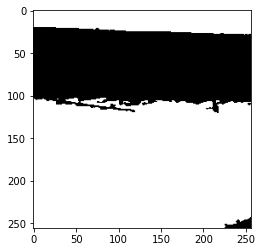

-33.67595818430886

In [318]:
path = '../../Data/TRAIN/'
f_img = cv2.imread(path + '004 Osmia lignaria f right 4x.jpg')
gray_f_img = cv2.cvtColor(f_img, cv2.COLOR_BGR2GRAY)

processed_img = preprocess_img(gray_f_img, None, display=False)

#window_img = processed_img[810-128:810+128,1130-128:1130+128]
window_img = processed_img[600-128:600+128,200-128:200+128]

plt.imshow(window_img, cmap='gray')
plt.show()

fd, hog_image = hog(window_img.astype(np.float32), orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)


new_data = fd.reshape((1, -1))
reduced_features_data = pca.transform(new_data)

kmeans.score(reduced_features_data)